In [1]:
from platform import python_version

print(python_version())

3.12.3


In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error,accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.feature_extraction import DictVectorizer


import mlflow
import mlflow.sklearn
import mlflow.xgboost
from mlflow.tracking import MlflowClient
import time
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shutil
import pickle


In [3]:
train_data = pd.read_csv("data/train_timeseries/train_timeseries.csv", sep=",")
test_data = pd.read_csv("data/test_timeseries/test_timeseries.csv", sep=",")
val_data = pd.read_csv("data/validation_timeseries/validation_timeseries.csv", sep=",")

In [4]:
print (len (train_data))
print (len (test_data))
print (len (val_data))

19300680
2271948
2268840


In [5]:
train_data.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN


In [6]:
train_data.describe()

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
count,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,2.756796e+06
mean,3.067038e+04,2.644145e+00,9.665578e+01,7.816178e+00,1.280146e+01,6.951072e+00,6.986916e+00,1.868141e+01,7.411665e+00,1.126974e+01,1.288900e+01,3.564013e+00,5.195993e+00,1.928879e+00,3.267113e+00,5.525151e+00,7.811798e+00,3.130077e+00,4.681721e+00,8.245298e-01
std,1.497911e+04,6.226305e+00,5.447994e+00,4.694305e+00,1.092674e+01,1.014551e+01,1.009116e+01,1.154487e+01,1.057680e+01,4.005165e+00,1.114961e+01,1.862297e+00,2.627969e+00,1.351713e+00,1.947028e+00,2.321549e+00,2.861210e+00,2.122751e+00,2.171263e+00,1.223727e+00
min,1.001000e+03,0.000000e+00,6.612000e+01,1.200000e-01,-3.734000e+01,-3.770000e+01,-3.746000e+01,-3.220000e+01,-4.596000e+01,3.000000e-02,-3.823000e+01,2.500000e-01,5.400000e-01,0.000000e+00,1.600000e-01,4.000000e-01,7.000000e-01,0.000000e+00,3.200000e-01,0.000000e+00
25%,1.904450e+04,0.000000e+00,9.584000e+01,3.780000e+00,4.450000e+00,-9.600000e-01,-9.200000e-01,1.027000e+01,-7.000000e-01,8.420000e+00,4.340000e+00,2.140000e+00,3.110000e+00,9.600000e-01,1.810000e+00,3.790000e+00,5.680000e+00,1.450000e+00,3.130000e+00,0.000000e+00
50%,2.921200e+04,1.800000e-01,9.830000e+01,6.840000e+00,1.402000e+01,7.570000e+00,7.580000e+00,2.040000e+01,8.030000e+00,1.124000e+01,1.404000e+01,3.140000e+00,4.670000e+00,1.660000e+00,2.800000e+00,5.120000e+00,7.310000e+00,2.770000e+00,4.250000e+00,0.000000e+00
75%,4.600750e+04,2.160000e+00,9.996000e+01,1.135000e+01,2.188000e+01,1.552000e+01,1.552000e+01,2.787000e+01,1.614000e+01,1.408000e+01,2.207000e+01,4.600000e+00,6.750000e+00,2.580000e+00,4.250000e+00,6.880000e+00,9.460000e+00,4.410000e+00,5.770000e+00,1.189600e+00
max,5.604300e+04,2.345900e+02,1.043200e+02,2.292000e+01,4.139000e+01,2.755000e+01,2.755000e+01,4.991000e+01,3.380000e+01,3.461000e+01,4.385000e+01,2.369000e+01,3.628000e+01,1.720000e+01,2.825000e+01,2.835000e+01,4.273000e+01,2.087000e+01,3.243000e+01,5.000000e+00


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19300680 entries, 0 to 19300679
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   date         object 
 2   PRECTOT      float64
 3   PS           float64
 4   QV2M         float64
 5   T2M          float64
 6   T2MDEW       float64
 7   T2MWET       float64
 8   T2M_MAX      float64
 9   T2M_MIN      float64
 10  T2M_RANGE    float64
 11  TS           float64
 12  WS10M        float64
 13  WS10M_MAX    float64
 14  WS10M_MIN    float64
 15  WS10M_RANGE  float64
 16  WS50M        float64
 17  WS50M_MAX    float64
 18  WS50M_MIN    float64
 19  WS50M_RANGE  float64
 20  score        float64
dtypes: float64(19), int64(1), object(1)
memory usage: 3.0+ GB


In [8]:
train_data.isnull().sum()

fips                  0
date                  0
PRECTOT               0
PS                    0
QV2M                  0
T2M                   0
T2MDEW                0
T2MWET                0
T2M_MAX               0
T2M_MIN               0
T2M_RANGE             0
TS                    0
WS10M                 0
WS10M_MAX             0
WS10M_MIN             0
WS10M_RANGE           0
WS50M                 0
WS50M_MAX             0
WS50M_MIN             0
WS50M_RANGE           0
score          16543884
dtype: int64

In [9]:
train_data = train_data.dropna()
test_data = test_data.dropna()
val_data = val_data.dropna()

In [10]:
train_data['score'].round().value_counts()

score
0.0    1652230
1.0     466944
2.0     295331
3.0     196802
4.0     106265
5.0      39224
Name: count, dtype: int64

In [11]:
train_data.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
10,1001,2000-01-11,1.33,100.40,6.63,11.48,7.84,7.84,18.88,5.72,...,10.43,1.76,2.48,1.05,1.43,3.55,6.38,1.71,4.67,2.0
17,1001,2000-01-18,1.11,100.39,9.53,14.28,13.26,13.26,18.04,8.98,...,14.19,2.63,3.60,1.67,1.92,5.19,6.40,3.84,2.55,2.0
24,1001,2000-01-25,0.00,100.11,2.05,-0.78,-7.93,-7.72,5.65,-5.46,...,-0.61,3.35,4.59,2.28,2.32,5.75,8.03,3.96,4.07,2.0
31,1001,2000-02-01,0.00,101.00,3.36,2.06,-1.73,-1.70,11.02,-4.21,...,1.88,2.03,2.74,0.88,1.86,4.18,6.38,1.27,5.11,1.0


In [12]:
def fix_datetime_and_score(df):
    df['year'] = pd.DatetimeIndex(df['date']).year
    df['month'] = pd.DatetimeIndex(df['date']).month
    df['day'] = pd.DatetimeIndex(df['date']).day
    df['score'] = df['score'].round().astype(int)
    return df

train_data = fix_datetime_and_score(train_data)
test_data = fix_datetime_and_score(test_data)
val_data = fix_datetime_and_score(val_data)
    

In [13]:
train_data.dtypes

fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score            int64
year             int32
month            int32
day              int32
dtype: object

In [14]:
len(train_data)

2756796

In [15]:
train_data.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,year,month,day
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,2.08,3.59,6.73,9.31,3.74,5.58,1,2000,1,4
10,1001,2000-01-11,1.33,100.40,6.63,11.48,7.84,7.84,18.88,5.72,...,1.05,1.43,3.55,6.38,1.71,4.67,2,2000,1,11
17,1001,2000-01-18,1.11,100.39,9.53,14.28,13.26,13.26,18.04,8.98,...,1.67,1.92,5.19,6.40,3.84,2.55,2,2000,1,18
24,1001,2000-01-25,0.00,100.11,2.05,-0.78,-7.93,-7.72,5.65,-5.46,...,2.28,2.32,5.75,8.03,3.96,4.07,2,2000,1,25
31,1001,2000-02-01,0.00,101.00,3.36,2.06,-1.73,-1.70,11.02,-4.21,...,0.88,1.86,4.18,6.38,1.27,5.11,1,2000,2,1


In [16]:
numerical_column_list = ['PRECTOT','PS','QV2M','T2M','T2MDEW','T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']
drought_df_measures = train_data[['PRECTOT','PS','QV2M','T2M','T2MDEW','T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']]

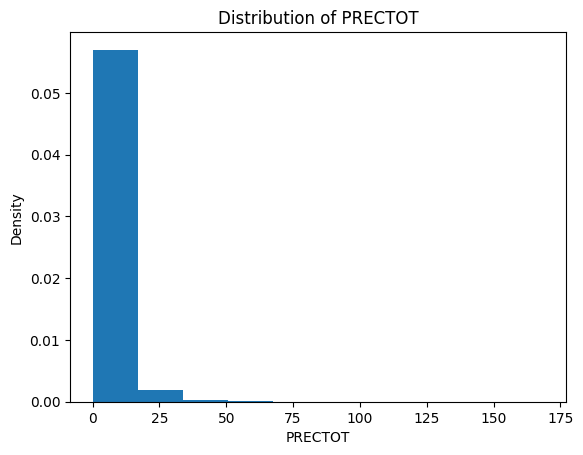

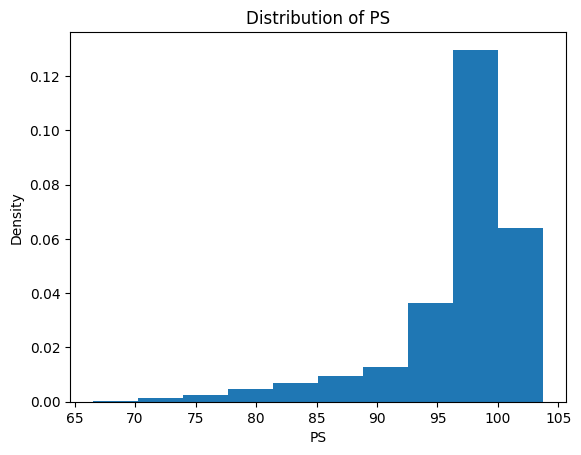

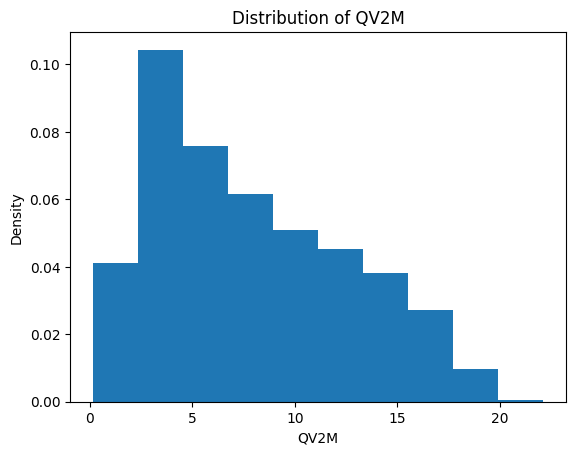

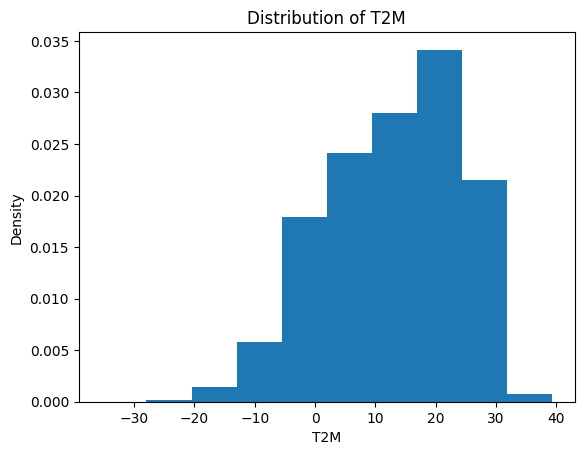

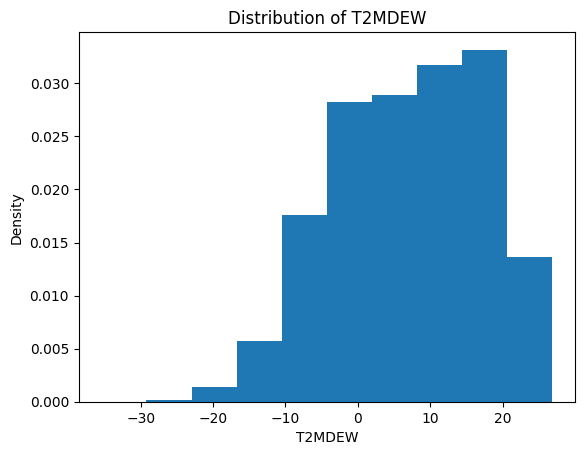

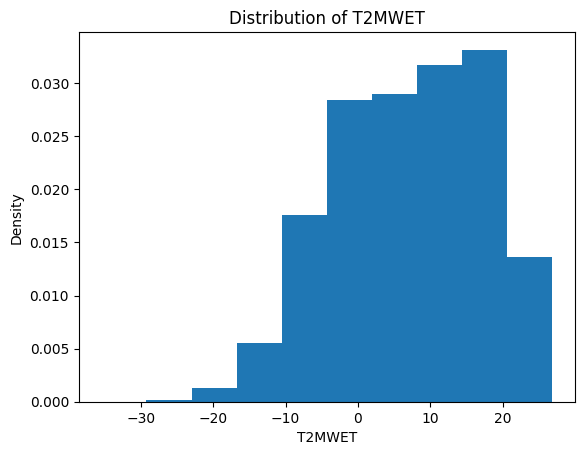

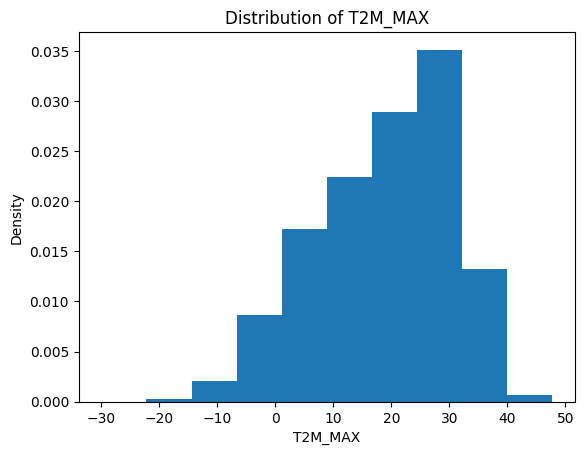

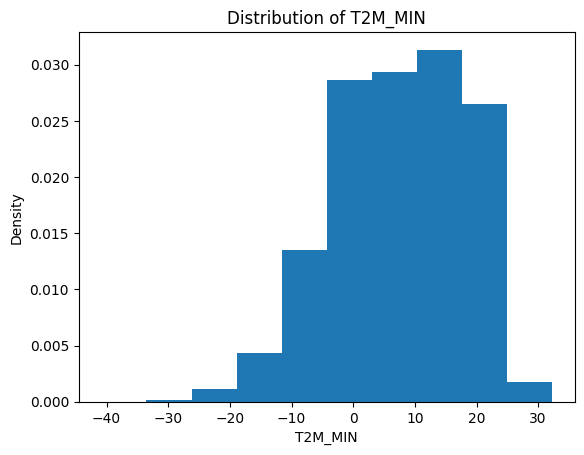

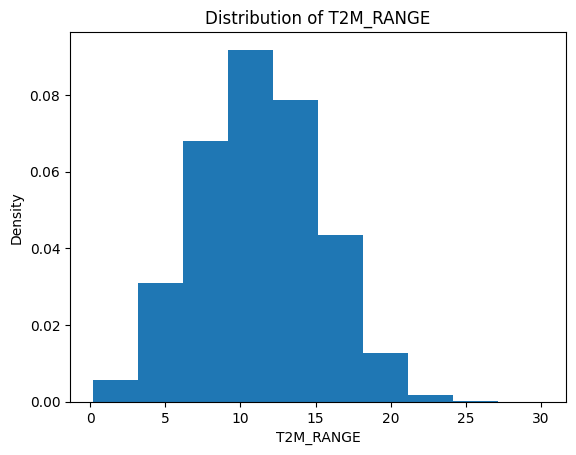

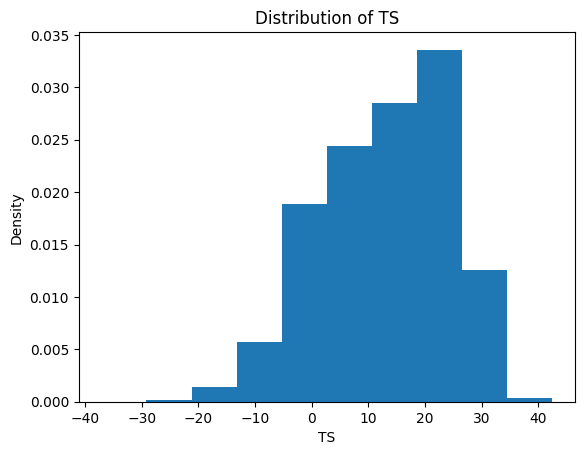

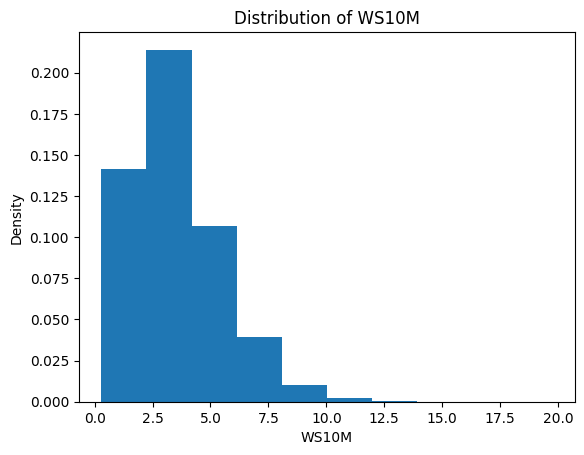

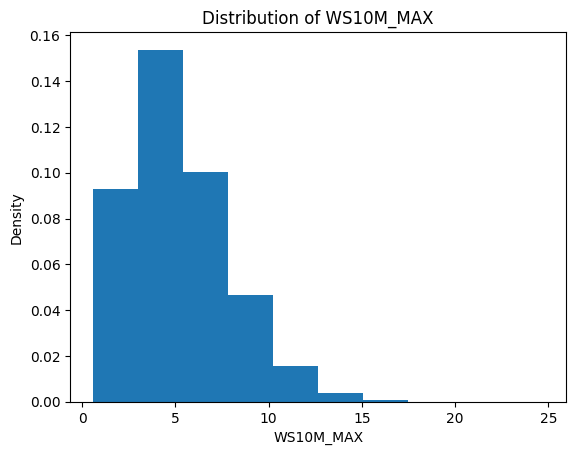

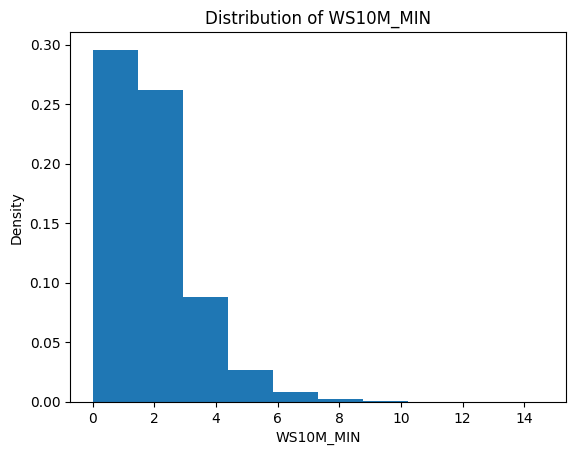

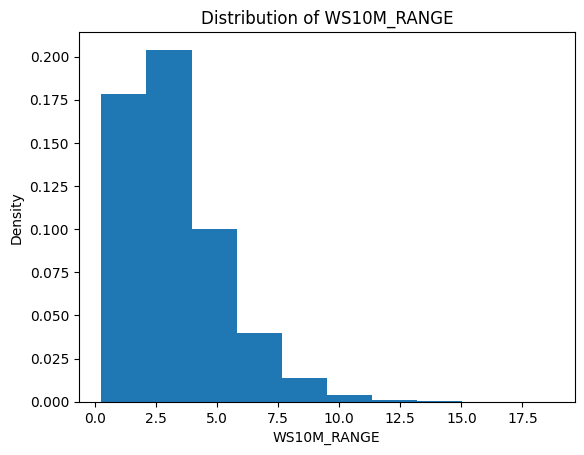

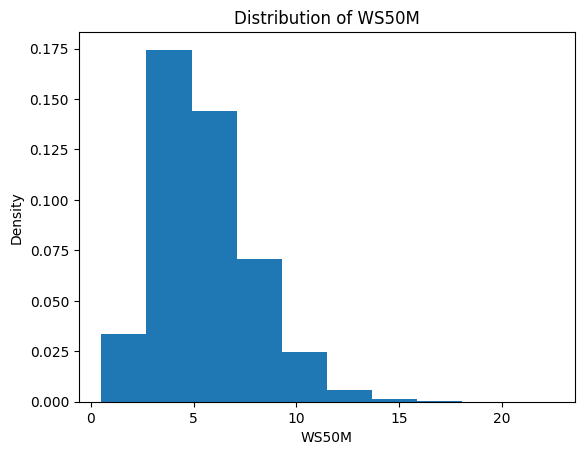

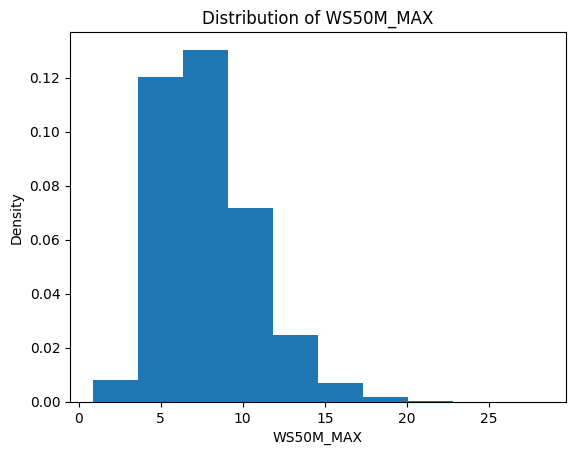

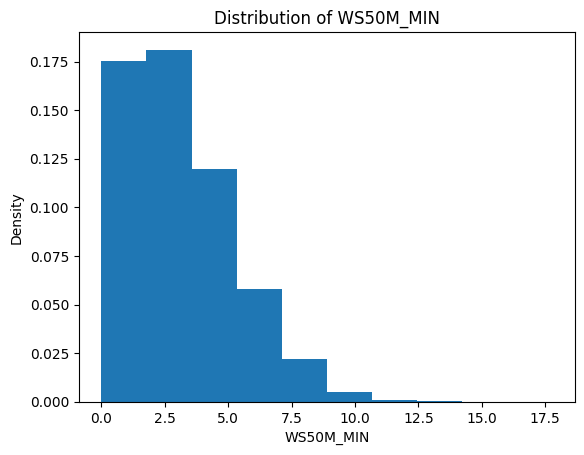

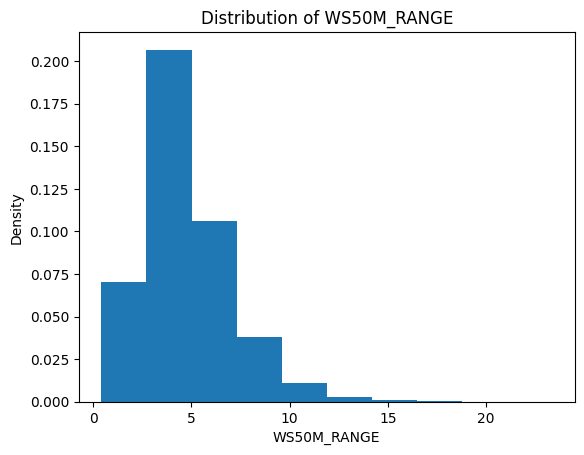

In [17]:
for col_name in numerical_column_list:
    plt.figure()
    plt.hist(drought_df_measures[col_name], density = True)
    x_name = col_name
    plt.xlabel(x_name)
    y_name = 'Density'
    plt.ylabel(y_name)
    plt.title('Distribution of {x_name}'.format(x_name=x_name))

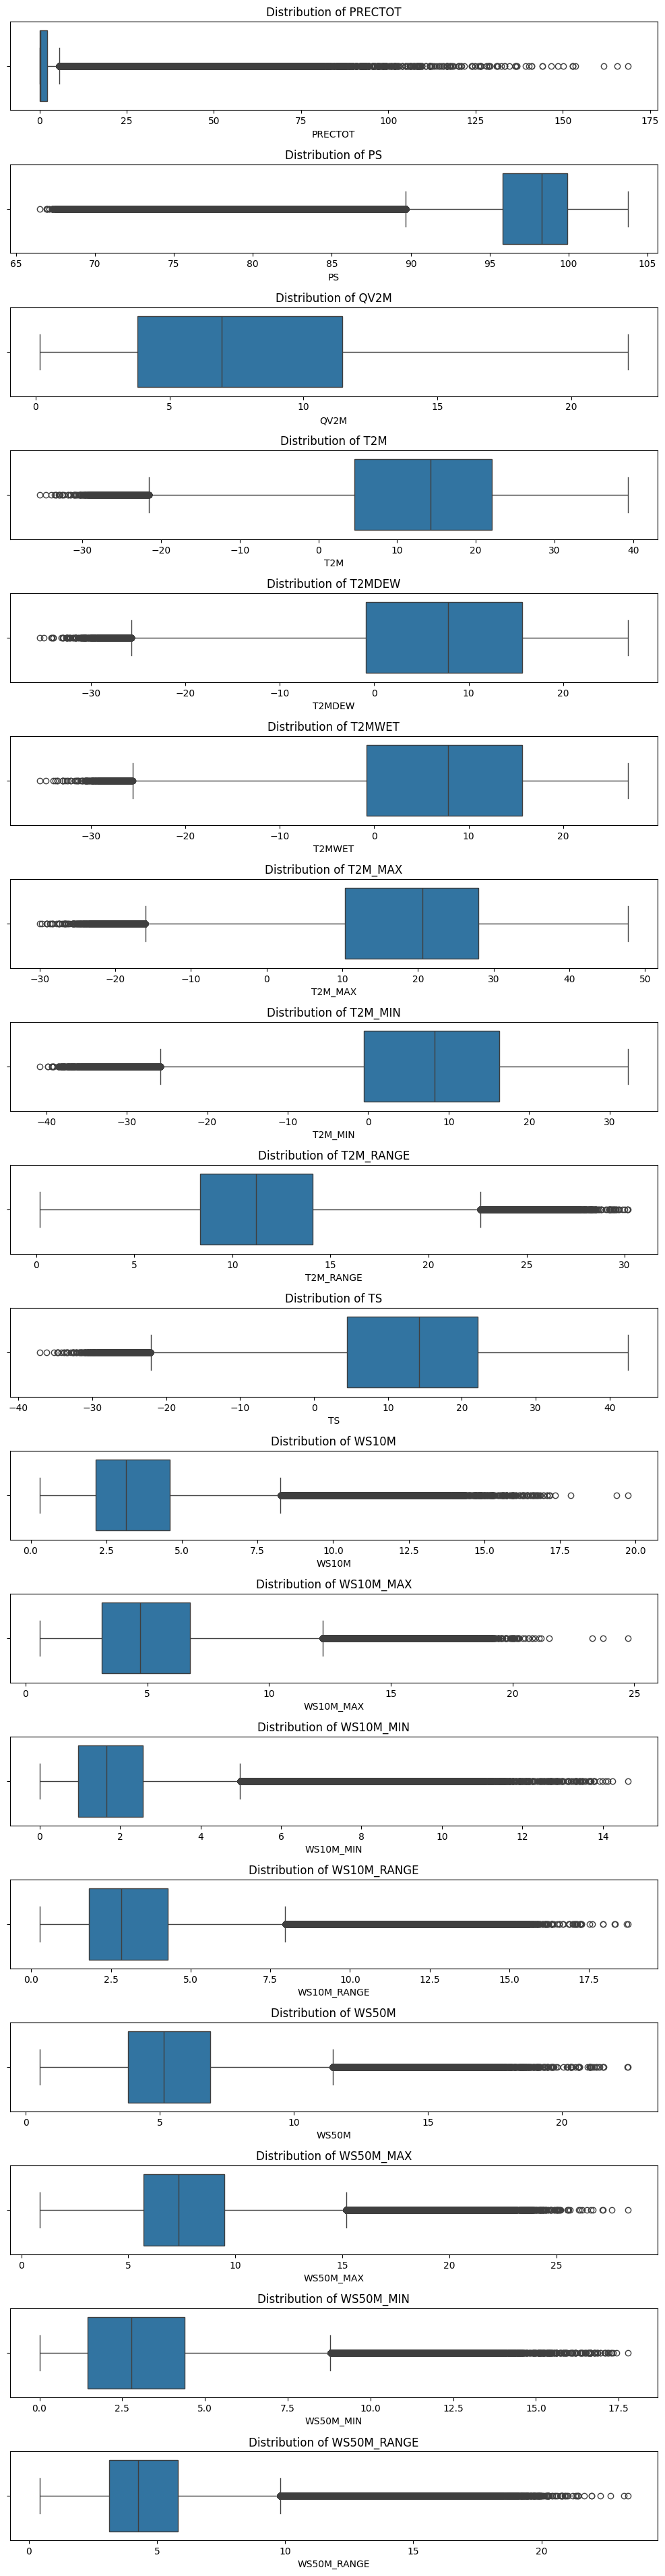

In [18]:
plt.figure(figsize=(10,40))
for x in (range(1,19)):
    plt.subplot(19,1,x)
    sns.boxplot(x =  drought_df_measures.columns[x-1], data=drought_df_measures)
    x_name = drought_df_measures.columns[x-1]
    plt.title(f'Distribution of {x_name}')         
plt.tight_layout()

In [19]:
print('Total rows = ',len(drought_df_measures))
for i in drought_df_measures.select_dtypes(exclude = ['object']).columns:
    print ('Number of values beyong standard outlier limit in ', i)
    print(len(drought_df_measures[(drought_df_measures[i] > drought_df_measures[i].mean() + 3*drought_df_measures[i].std()) | (drought_df_measures[i] < drought_df_measures[i].mean() - 3*drought_df_measures[i].std())]))

Total rows =  2756796
Number of values beyong standard outlier limit in  PRECTOT
65933
Number of values beyong standard outlier limit in  PS
73197
Number of values beyong standard outlier limit in  QV2M
1
Number of values beyong standard outlier limit in  T2M
4531
Number of values beyong standard outlier limit in  T2MDEW
2023
Number of values beyong standard outlier limit in  T2MWET
1814
Number of values beyong standard outlier limit in  T2M_MAX
3384
Number of values beyong standard outlier limit in  T2M_MIN
6944
Number of values beyong standard outlier limit in  T2M_RANGE
3628
Number of values beyong standard outlier limit in  TS
4762
Number of values beyong standard outlier limit in  WS10M
29954
Number of values beyong standard outlier limit in  WS10M_MAX
23387
Number of values beyong standard outlier limit in  WS10M_MIN
39901
Number of values beyong standard outlier limit in  WS10M_RANGE
35979
Number of values beyong standard outlier limit in  WS50M
23090
Number of values beyong sta

In [20]:
def remove_outliers(df):
    for col_name in numerical_column_list:
        df = df[(df[col_name] <= df[col_name].mean() + 3*df[col_name].std()) &
            (df[col_name] >= df[col_name].mean() - 3*df[col_name].std())]
    return df

train_data = remove_outliers(train_data)
test_data = remove_outliers(test_data)
val_data = remove_outliers(val_data)

In [21]:
len(train_data)


2474338

In [22]:
len(test_data)

292895

<Figure size 1000x4000 with 0 Axes>

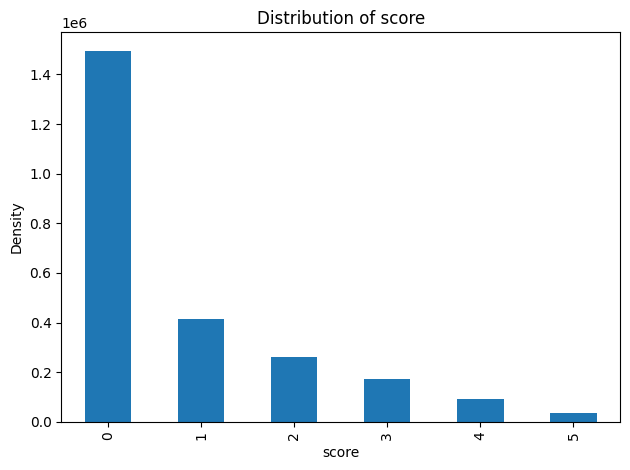

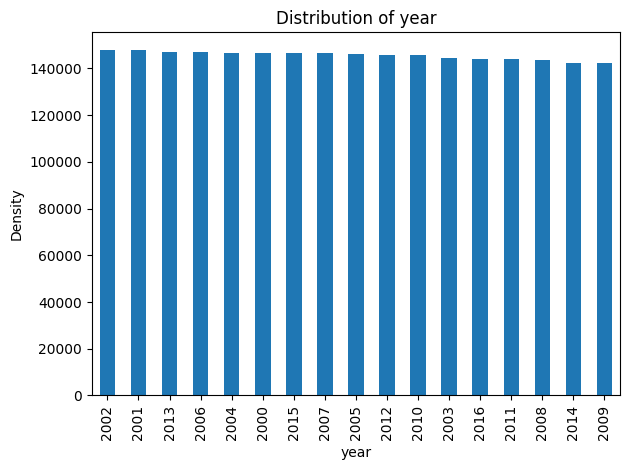

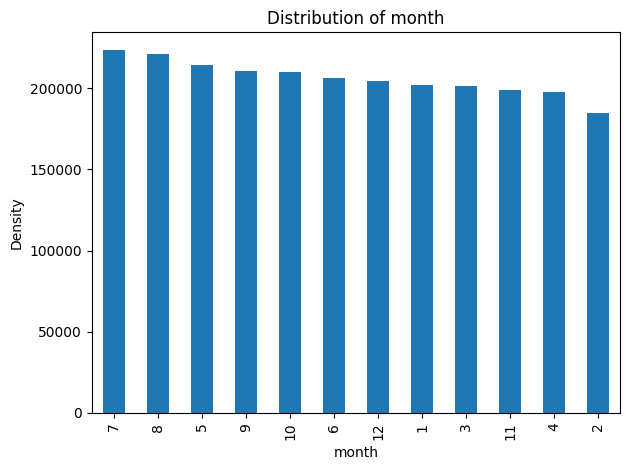

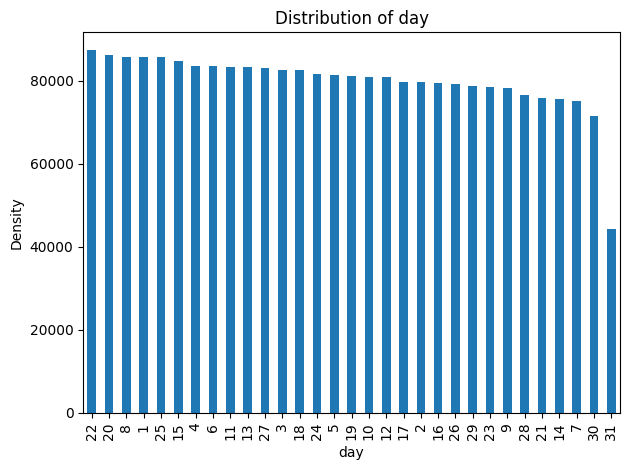

In [23]:
categorical_column_list = ['score','year','month','day']
drought_df_categorical = train_data[['score','year','month','day']]

# Distribution of categorical variables
plt.figure(figsize=(10,40))
for col_name in categorical_column_list:
    plt.figure()
    drought_df_categorical[col_name].value_counts().plot(kind = 'bar')
    x_name = col_name
    y_name = 'Density'
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title('Distribution of {x_name}'.format(x_name=x_name))
    plt.tight_layout()

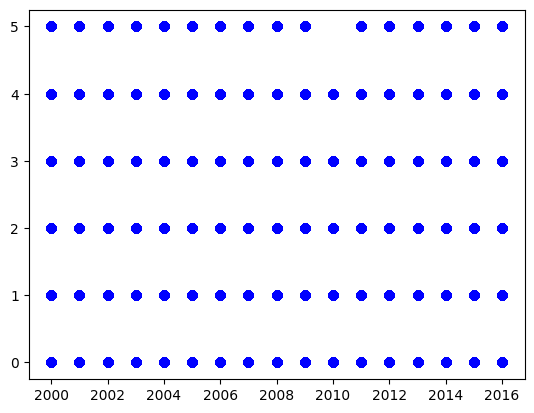

In [24]:
plt.scatter(train_data['year'], train_data['score'], c ="blue")
plt.show()

In [25]:
train_data.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,year,month,day
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,2.08,3.59,6.73,9.31,3.74,5.58,1,2000,1,4
10,1001,2000-01-11,1.33,100.40,6.63,11.48,7.84,7.84,18.88,5.72,...,1.05,1.43,3.55,6.38,1.71,4.67,2,2000,1,11
17,1001,2000-01-18,1.11,100.39,9.53,14.28,13.26,13.26,18.04,8.98,...,1.67,1.92,5.19,6.40,3.84,2.55,2,2000,1,18
24,1001,2000-01-25,0.00,100.11,2.05,-0.78,-7.93,-7.72,5.65,-5.46,...,2.28,2.32,5.75,8.03,3.96,4.07,2,2000,1,25
31,1001,2000-02-01,0.00,101.00,3.36,2.06,-1.73,-1.70,11.02,-4.21,...,0.88,1.86,4.18,6.38,1.27,5.11,1,2000,2,1


In [26]:
def remove_fips_and_date(df):
    df = df.drop("fips", axis=1)
    df = df.drop("date", axis=1)
    return df
    
train_data = remove_fips_and_date(train_data)
test_data = remove_fips_and_date(test_data)
val_data = remove_fips_and_date(val_data)

In [27]:
correlation_plot = train_data.corr()
correlation_plot.style.background_gradient(cmap = 'RdYlGn')

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,year,month,day
PRECTOT,1.000000,0.051470,0.284634,0.117007,0.262642,0.262567,0.043930,0.177954,-0.343956,0.113807,0.001778,0.010417,-0.009614,0.020658,0.014459,0.006348,0.033493,-0.025964,-0.060739,0.009231,0.016374,0.003078
PS,0.051470,1.000000,0.258551,0.121002,0.301899,0.301761,0.074383,0.161513,-0.211641,0.116805,-0.106831,-0.162464,0.012949,-0.227981,-0.060541,-0.119919,0.030308,-0.184376,-0.182149,-0.006806,-0.002554,-0.005768
QV2M,0.284634,0.258551,1.000000,0.875095,0.962860,0.963820,0.810068,0.911854,-0.058398,0.867656,-0.217262,-0.246679,-0.101331,-0.262929,-0.201012,-0.250720,-0.076152,-0.243475,-0.040668,0.046277,0.150730,0.000955
T2M,0.117007,0.121002,0.875095,1.000000,0.915036,0.915705,0.983863,0.982230,0.261250,0.997745,-0.193542,-0.204741,-0.113367,-0.198097,-0.185187,-0.198463,-0.106887,-0.145288,0.098238,0.015740,0.196964,0.008433
T2MDEW,0.262642,0.301899,0.962860,0.915036,1.000000,0.999975,0.858324,0.940878,0.005209,0.906540,-0.230004,-0.259305,-0.106937,-0.276098,-0.198160,-0.245111,-0.076230,-0.236215,-0.045372,0.035950,0.169732,0.007174
T2MWET,0.262567,0.301761,0.963820,0.915705,0.999975,1.000000,0.858991,0.941555,0.005357,0.907248,-0.229845,-0.259076,-0.106992,-0.275752,-0.198248,-0.245136,-0.076387,-0.236087,-0.044671,0.036084,0.169715,0.007117
T2M_MAX,0.043930,0.074383,0.810068,0.983863,0.858324,0.858991,1.000000,0.939692,0.421068,0.981023,-0.199604,-0.204828,-0.125578,-0.189813,-0.183040,-0.182207,-0.124655,-0.106390,0.134755,0.006662,0.194038,0.004930
T2M_MIN,0.177954,0.161513,0.911854,0.982230,0.940878,0.941555,0.939692,1.000000,0.085450,0.979753,-0.193177,-0.209936,-0.104081,-0.211491,-0.192209,-0.221578,-0.092348,-0.189681,0.068713,0.024041,0.210619,0.010379
T2M_RANGE,-0.343956,-0.211641,-0.058398,0.261250,0.005209,0.005357,0.421068,0.085450,1.000000,0.259544,-0.069167,-0.039938,-0.089801,0.007924,-0.023481,0.056832,-0.118228,0.193101,0.210332,-0.044345,0.006698,-0.013161
TS,0.113807,0.116805,0.867656,0.997745,0.906540,0.907248,0.981023,0.979753,0.259544,1.000000,-0.174931,-0.186172,-0.098454,-0.183316,-0.172521,-0.184477,-0.096901,-0.137547,0.106373,0.014657,0.190751,0.008821


In [28]:
# Some variables almost correlate at 1. Lets check for their variance.

def plot_scatter_variance(label1, label2):
    #temp_df = train_data[train_data['score']==5]
    plt.scatter(train_data[label1], train_data[label2], c= train_data['score'])
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.title(f'Variation of {label1} vs {label2}')
    plt.show()

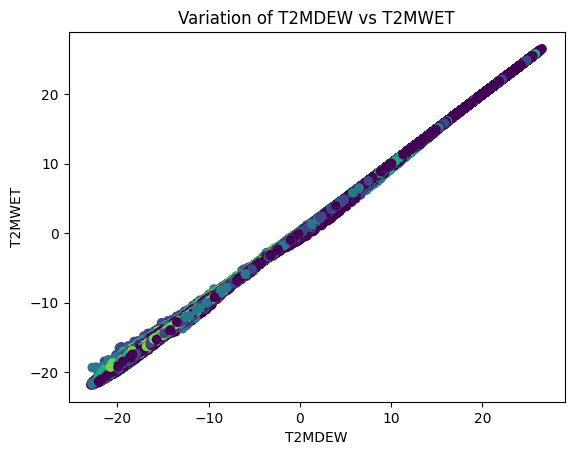

In [29]:
plot_scatter_variance("T2MDEW","T2MWET")

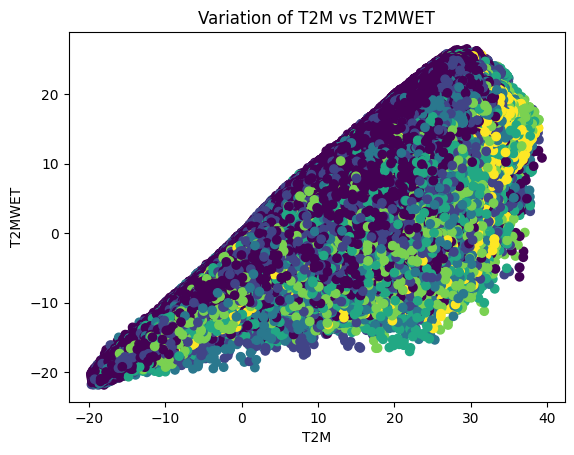

In [30]:
plot_scatter_variance("T2M","T2MWET")

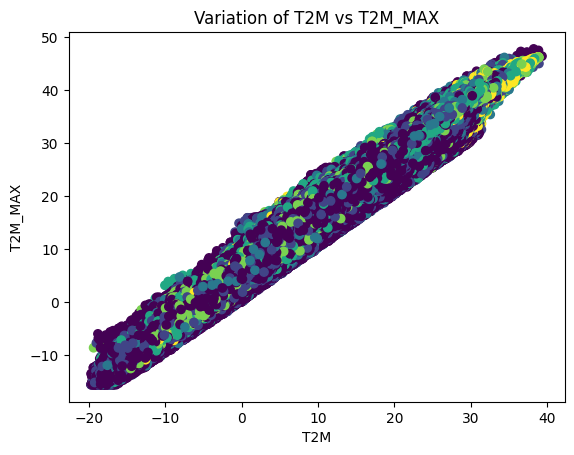

In [31]:
plot_scatter_variance("T2M","T2M_MAX")

In [32]:
# we will remove the ones with 0.99 or above
def remove_invariates(df):
    df = df.drop("TS",axis=1)
    df = df.drop("T2MWET",axis=1)
    return df
    
train_data = remove_invariates(train_data)
test_data = remove_invariates(test_data)
val_data = remove_invariates(val_data)


In [33]:
dv = DictVectorizer()

categorical_column_list = ['year','month','day']
numerical_column_list = ['PRECTOT','PS','QV2M','T2M','T2MDEW','T2M_MAX','T2M_MIN','T2M_RANGE','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']


df_train = train_data.drop('score', axis=1)
train_dicts = df_train[categorical_column_list + numerical_column_list].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
y_train = train_data["score"]

df_val = val_data.drop('score', axis=1)
val_dicts = df_val[categorical_column_list + numerical_column_list].to_dict(orient='records')
X_val = dv.fit_transform(val_dicts)
y_val = val_data["score"]

df_test = test_data.drop('score', axis=1)
test_dicts = df_test[categorical_column_list + numerical_column_list].to_dict(orient='records')
X_test = dv.fit_transform(test_dicts)
y_test = test_data["score"]


In [34]:
def check_disk_space():
    total, used, free = shutil.disk_usage("/")
    print(f"Total: {total // (2**30)} GB")
    print(f"Used: {used // (2**30)} GB")
    print(f"Free: {free // (2**30)} GB")

Disk space before training:
Total: 479 GB
Used: 383 GB
Free: 71 GB


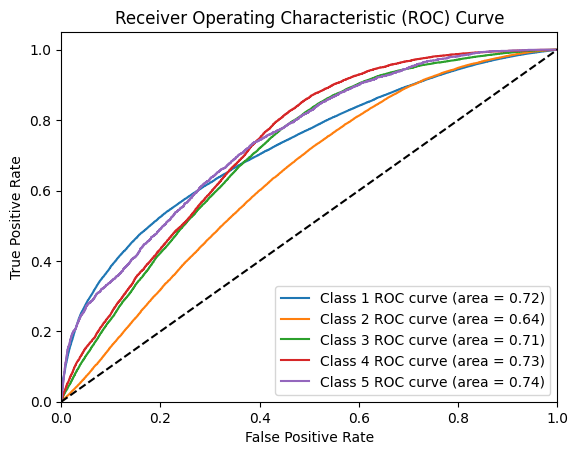

/home/ibai/.local/share/virtualenvs/Drought-predictor-project-Ud97grmN/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:39:21] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
Registered model 'drought-prediction-model' already exists. Creating a new version of this model...
Created version '2' of model 'drought-prediction-model'.


Training Duration: 44.399254322052
Validation Mean Squared Error: 1.0797704111514583
Test Mean Squared Error: 0.7926833848307414
Validation Accuracy: 0.6730150417904072
Test Accuracy: 0.7489339182983663
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.96      0.87    225111
           1       0.21      0.08      0.12     38208
           2       0.20      0.05      0.07     18949
           3       0.13      0.02      0.04      7793
           4       0.11      0.02      0.04      2389
           5       0.00      0.00      0.00       445

    accuracy                           0.75    292895
   macro avg       0.24      0.19      0.19    292895
weighted avg       0.65      0.75      0.69    292895

Confusion Matrix:
 [[215227   7003   1647    589    178    467]
 [ 33683   3058   1062    199     75    131]
 [ 15334   2440    857    146     89     83]
 [  5641   1355    457    161    102     77]
 [  1474    568    160    115  

In [48]:
# Define the model
#model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=12)
model = xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=12)
#model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=12)

# Binarize the output for multiclass ROC
y_bin = label_binarize(y_train, classes=[1, 2, 3, 4, 5])
n_classes = y_bin.shape[1]

# Check disk space before training
print("Disk space before training:")
check_disk_space()

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("drought-prediction-experiment")

# Start an MLflow run
with mlflow.start_run():

    mlflow.set_tag("developer", "Ibai")
    mlflow.set_tag("model", "xgboost")
    
    start_time = time.time()

    # Train the model
    model.fit(X_train, y_train)

    end_time = time.time()
    training_duration = end_time - start_time
    
    # Make predictions on the validation set
    val_predictions = model.predict(X_val)
    val_mse = mean_squared_error(y_val, val_predictions)
    val_accuracy = accuracy_score(y_val, val_predictions)

    # Make predictions on the test set
    test_predictions = model.predict(X_test)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)

    # Get probability predictions for ROC curve
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])
    y_score = model.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i+1} ROC curve (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig("roc_curve.png")
    plt.show()
    
    # Log parameters and metrics
    mlflow.log_param("n_estimators", 100)
    mlflow.log_metric("val_mse", val_mse)
    mlflow.log_metric("test_mse", test_mse)
    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("training_duration", training_duration)

    # Save the model locally
    model_path = 'models/model_xgboost.bin'
    with open(model_path, 'wb') as f_out:
        pickle.dump((dv, model), f_out)
    
    # Log the model
    #mlflow.sklearn.log_model(model, "model")
    mlflow.xgboost.log_model(model, "model")
    mlflow.log_artifact(local_path="models/model_xgboost.bin", artifact_path="models_pickle")

    # Register the model in the MLflow Model Registry
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
    registered_model = mlflow.register_model(model_uri, "drought-prediction-model")

print (f"Training Duration: {training_duration}")
print(f"Validation Mean Squared Error: {val_mse}")
print(f"Test Mean Squared Error: {test_mse}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print("Classification Report:\n", classification_report(y_test, test_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, test_predictions))

In [49]:
model_name = "drought-prediction-model"
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

latest_versions = client.get_latest_versions(name=model_name)

for version in latest_versions:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 1, stage: Staging
version: 2, stage: None


/tmp/ipykernel_10986/2634880133.py:5: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest_versions = client.get_latest_versions(name=model_name)


In [50]:
# Version of the registered model to promote
model_version = registered_model.version  # The version obtained from the registration step

new_stage = "Staging"
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage
)
print(f"Model version {model_version} of '{model_name}' has been promoted to 'Staging'.")


Model version 2 of 'drought-prediction-model' has been promoted to 'Staging'.


/tmp/ipykernel_10986/3132423768.py:5: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


In [52]:
for version in latest_versions:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 1, stage: Staging
version: 2, stage: None


### make a simple prediction

In [36]:
train_data


,PRECTOT,PS,QV2M,T2M,T2MDEW,T2M_MAX,T2M_MIN,T2M_RANGE,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,year,month,day
3,15.95,100.29,6.42,11.40,6.09,18.09,2.16,15.92,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1,2000,1,4
10,1.33,100.40,6.63,11.48,7.84,18.88,5.72,13.16,1.76,2.48,1.05,1.43,3.55,6.38,1.71,4.67,2,2000,1,11
17,1.11,100.39,9.53,14.28,13.26,18.04,8.98,9.06,2.63,3.60,1.67,1.92,5.19,6.40,3.84,2.55,2,2000,1,18
24,0.00,100.11,2.05,-0.78,-7.93,5.65,-5.46,11.11,3.35,4.59,2.28,2.32,5.75,8.03,3.96,4.07,2,2000,1,25
31,0.00,101.00,3.36,2.06,-1.73,11.02,-4.21,15.23,2.03,2.74,0.88,1.86,4.18,6.38,1.27,5.11,1,2000,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19300647,0.04,82.47,2.19,-4.27,-9.36,-1.51,-7.22,5.71,6.93,10.27,3.08,7.18,9.42,12.59,5.62,6.97,0,2016,11,29
19300654,0.13,82.59,0.91,-11.96,-18.65,-6.85,-15.24,8.39,2.27,3.97,0.95,3.02,3.07,5.16,0.83,4.33,0,2016,12,6
19300661,0.02,82.86,1.40,-9.56,-14.18,-2.69,-13.01,10.32,3.64,6.59,1.28,5.31,5.33,8.35,2.13,6.22,0,2016,12,13
19300668,0.32,83.12,2.73,-2.55,-6.90,2.66,-7.77,10.42,6.16,8.43,3.44,4.99,8.99,10.14,6.67,3.47,0,2016,12,20


In [37]:
sample = {'PRECTOT': [10], 
          'PS' : [90], 
          'QV2M': [3], 
          'T2M': [5], 
          'T2MDEW': [-3], 
          'T2M_MAX': [15], 
          'T2M_MIN': [1],
          'T2M_RANGE': [14],
          'WS10M': [4],
          'WS10M_MAX': [5],
          'WS10M_MIN': [2],
          'WS10M_RANGE': [3],
          'WS50M': [8],
          'WS50M_MAX': [10],
          'WS50M_MIN': [0],
          'WS50M_RANGE': [10],
          'year': [2024], 
          'month': [7],
          'day': [19]}
sample = pd.DataFrame(sample)

In [38]:
model.predict(sample)[0]

1